Section 1: set up models


In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# From ATTA
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline

In [ ]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Step 2: Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


In [ ]:
# set up PGD-20 attack
eps = 0.2
pgd20 = ProjectedGradientDescentPyTorch(
        estimator=classifier,
        norm="inf",
        eps=eps,
        eps_step=0.05,
        max_iter=20
    )

Section 2: adversarial training a classifier using PGD-20 

In [ ]:
for i in range(4):
  x_train_adv = pgd20.generate(x=x_train)
  classifier.fit(x_train_adv, y_train, batch_size=64, nb_epochs=1)

  predictions = classifier.predict(x_test)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  print("Epoch ", i, ", Accuracy on benign test examples: {}%".format(accuracy * 100))

/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Epoch  0 , Accuracy on benign test examples: 97.33000000000001%


Epoch  1 , Accuracy on benign test examples: 96.32%


Epoch  2 , Accuracy on benign test examples: 97.13000000000001%


Epoch  3 , Accuracy on benign test examples: 96.57%


In [ ]:
# Generate PGD-20 attacks on T4
y_label = np.argmax(y_train, axis=1)
y_label_tensor = torch.from_numpy(y_label.astype(np.int_)).to(device)
x_train_adv_5 = pgd20.generate(x=x_train)
adv_predictions_5 = classifier.predict(x_train_adv_5)
x_adv_tensor = torch.from_numpy(x_train_adv_5).to(device)
loss_adv_5 = criterion(model(x_adv_tensor), y_label_tensor)
print("PGD-20 generate loss on T4: ", loss_adv_5)

/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


PGD-20 generate loss on T4:  tensor(5.5621, grad_fn=<NllLossBackward>)


Section 3: adversarial training a classifier using ATTA-5

In [ ]:
# set up PGD-5 attack for ATTA
model2 = Net().to(device)
classifierATTA = PyTorchClassifier(
    model=model2,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


eps = 0.2
pgd5 = ProjectedGradientDescentPyTorch(
        estimator=classifierATTA,
        norm="inf",
        eps=eps,
        eps_step=0.05,
        max_iter=5
    )

In [ ]:
x_ATTA = x_train
for i in range(4):
  x_ATTA = pgd5.generate(x=x_ATTA)
  classifierATTA.fit(x_train_adv, y_train, batch_size=64, nb_epochs=1)

  predictions = classifierATTA.predict(x_test)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  print("Epoch ", i, ", Accuracy on benign test examples: {}%".format(accuracy * 100))

/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Epoch  0 , Accuracy on benign test examples: 97.00999999999999%


Epoch  1 , Accuracy on benign test examples: 97.0%


Epoch  2 , Accuracy on benign test examples: 96.67%


Epoch  3 , Accuracy on benign test examples: 97.38%


In [ ]:
adv_predictions_atta = classifier.predict(x_ATTA)
x_adv_tensor = torch.from_numpy(x_ATTA).to(device)
loss_adv_atta = criterion(model(x_adv_tensor), y_label_tensor)
print("ATTA generate loss on T4: ", loss_adv_atta)

ATTA generate loss on T4:  tensor(4.9551, grad_fn=<NllLossBackward>)


Section 4: Compare attacks from different adversarial training

Text(0.5, 1.0, 'PGD-20 attack on T4')

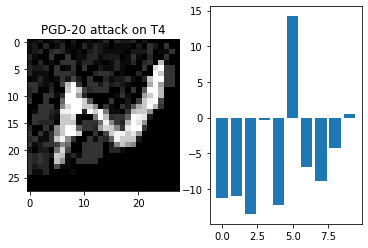

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x_train_adv[0][0], cmap='gray')
ax2.bar(np.arange(0,10), adv_predictions_5[0])
ax1.set_title('PGD-20 attack on T4')

Text(0.5, 1.0, 'ATTA-5 epoch 4 attack')

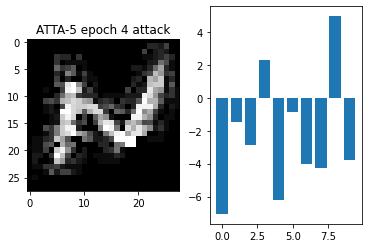

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x_ATTA[0][0], cmap='gray')
ax2.bar(np.arange(0,10), adv_predictions_atta[0])
ax1.set_title('ATTA-5 epoch 4 attack')

Text(0.5, 1.0, 'PGD-20 attack on T4')

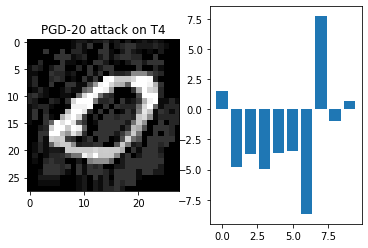

In [ ]:
# Comparison 2 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x_train_adv[1][0], cmap='gray')
ax2.bar(np.arange(0,10), adv_predictions_5[1])
ax1.set_title('PGD-20 attack on T4')

Text(0.5, 1.0, 'ATTA-5 epoch 4 attack')

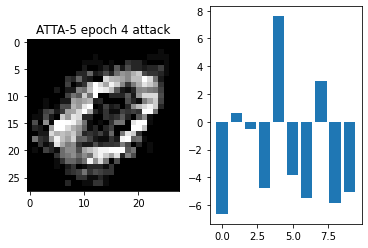

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(x_ATTA[1][0], cmap='gray')
ax2.bar(np.arange(0,10), adv_predictions_atta[1])
ax1.set_title('ATTA-5 epoch 4 attack')